In [1]:
import scipy 
import matplotlib.pyplot as plt
import math
import autograd.numpy as np
from autograd import grad

/Users/freeklinssen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


first we do the example again from Simple_Metropolis-Hastings.ipynb because for this prior and likelihood, the posterior distribution can be calculated directly as P(p∣k,n) ∼ Beta(α+k,β+n−k) in this case, enabling us to verify the results of the Hamiltonian algorithms:

We have a school with 1000 kids and want to estimate the probability distribution of what percentage of the kids on this school have read a particular book.

* We survayed 40 kids and 16 of them read the book

* As prior knowledge, we know that the reading percentage of this book at schools across the country is distributed according to the function Beta(3, 7) 


Using Bayes' theorem, we can now derive the posterior probability distribution of the reading percentage at our school based on the survey results and the prior information.

In this case the prior distribution of p is defined by:
* p ∼ Beta(α, β) 

The likelihood of observing the data (number of students who read the book out of those surveyed) can be modeled using a binomial distribution:
* k|p ∼ Binomial(n, p) 



 
​

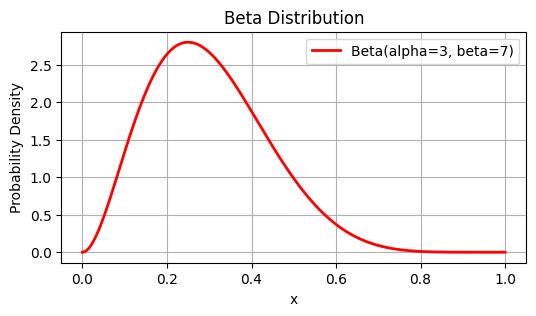

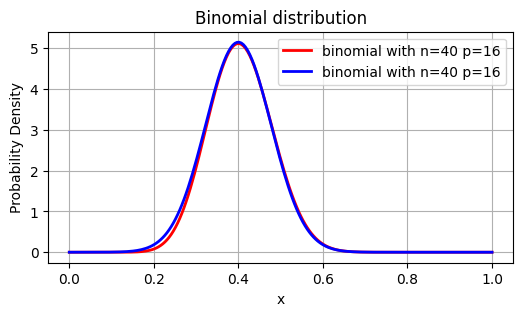

In [2]:
# the distribution in the population (the prior)
alpha = 3
beta = 7
n=40
k=16

x = np.linspace(0, 1, 200)

y = scipy.stats.beta.pdf(x, alpha, beta)

plt.figure(figsize=(6, 3))
plt.plot(x, y, 'r-', lw=2, label=f'Beta(alpha={alpha}, beta={beta})')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Beta Distribution')
plt.legend()
plt.grid(True)
plt.show()


x = np.linspace(0, 1, 200)
y = scipy.stats.binom.pmf(k, n, x)
y_2 =  scipy.stats.norm.pdf(x, (k/n), np.sqrt(n*(k/n)*(1-(k/n)))/n)

plt.figure(figsize=(6, 3))
plt.plot(x, y*n, 'r-', lw=2, label=f'binomial with n={n} p={k}')
plt.plot(x, y_2, 'b-', lw=2, label=f'binomial with n={n} p={k}')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Binomial distribution')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
def log_posterior_calculator(position):
    log_prob = (3-1)*np.log(position) + (7-1)*np.log(1-position)
    log_prob += np.log(math.comb(n, k)) + k*np.log(position) +(n-k)*np.log(1-position)
    return log_prob

total_grad = grad(log_posterior_calculator) 

def log_posterior_grad_calculator(position):    
    return total_grad(position)

First the simple Hamiltonian Monte Carlo Algorithm without no U-turn sampling and adaptive step size.

In [4]:
from simple_HMC import HamiltonianMC

HamiltonianMCMC = HamiltonianMC(log_posterior_calculator, log_posterior_grad_calculator, n_steps = None, step_size = 0.01)

start_position = np.array([k/n])
samples_1 = HamiltonianMCMC.sample(start_position, n_samples = 10000, burn_in=1000)

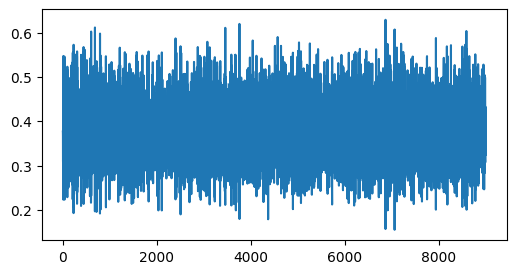

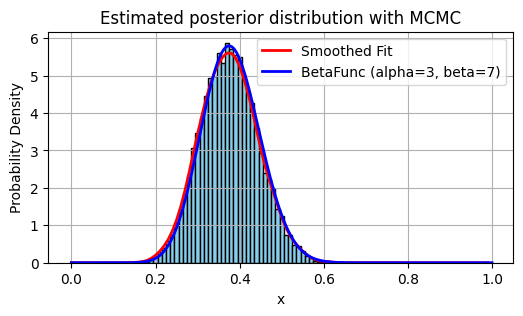

In [5]:
bins = np.arange(0, 1.01, 0.01)
counts, bin_edges = np.histogram(samples_1, bins=bins)
counts = counts/len(samples_1)/0.01

smoothed_counts = scipy.ndimage.gaussian_filter1d(counts, sigma=1.5)  #Adjust sigma for smoothness

# for the true distribution:
x = np.linspace(0, 1, 200)
y = scipy.stats.beta.pdf(x, alpha+k, beta+n-k)


# Plotting
fig, axes = plt.subplots(1, figsize=(6, 3))
axes.plot(samples_1)
plt.show()
    
plt.figure(figsize=(6, 3))
plt.bar(bin_edges[:-1], counts, width=0.01, color='skyblue', edgecolor='black')
plt.plot(bin_edges[:-1], smoothed_counts, color='red', lw=2, label="Smoothed Fit")
plt.plot(x, y, 'b-', lw=2, label=f'BetaFunc (alpha={alpha}, beta={beta})')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Estimated posterior distribution with MCMC')
plt.grid(True)
plt.legend()
plt.show()

Now the Hamiltonian Monte Carlo Algorithm with no U-turn sampling and adaptive step size.

In [8]:
from HMC__no_u_turn import HamiltonianMC_no_uturn

HamiltonianMCMC = HamiltonianMC_no_uturn(log_posterior_calculator, log_posterior_grad_calculator)

start_position = np.array([k/n])
samples_2 = HamiltonianMCMC.sample(start_position, n_samples = 10000, burn_in=1000)
samples_2 = HamiltonianMCMC.sample(start_position, n_samples = 10000, burn_in=1000, step_size =0.01, update_step_size = False)

100.0


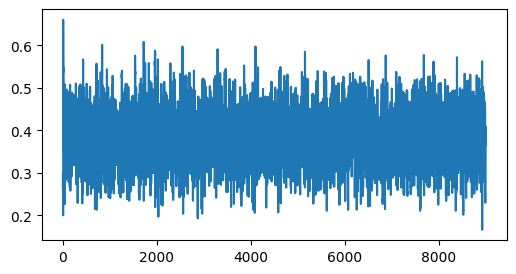

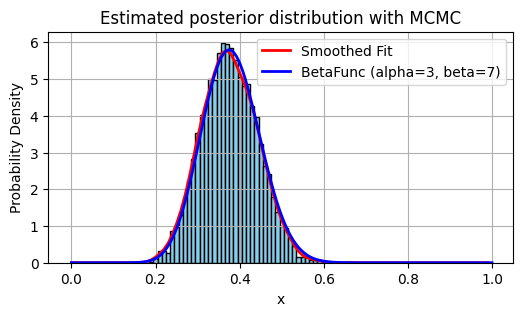

In [9]:
bins = np.arange(0, 1.01, 0.01)
counts, bin_edges = np.histogram(samples_2, bins=bins)
counts = counts/len(samples_2)/0.01

print(sum(counts))
smoothed_counts = scipy.ndimage.gaussian_filter1d(counts, sigma=1.5)  #Adjust sigma for smoothness

# for the true distribution:
x = np.linspace(0, 1, 200)
y = scipy.stats.beta.pdf(x, alpha+k, beta+n-k)

# Plotting
fig, axes = plt.subplots(1, figsize=(6, 3))
axes.plot(samples_2)
plt.show()
    
plt.figure(figsize=(6, 3))
plt.bar(bin_edges[:-1], counts, width=0.01, color='skyblue', edgecolor='black')
plt.plot(bin_edges[:-1], smoothed_counts, color='red', lw=2, label="Smoothed Fit")
plt.plot(x, y, 'b-', lw=2, label=f'BetaFunc (alpha={alpha}, beta={beta})')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Estimated posterior distribution with MCMC')
plt.grid(True)
plt.legend()
plt.show()

One last regression example taken from https://github.com/fonnesbeck/scientific-python-workshop/blob/master/notebooks/MCMC.ipynb:

In [28]:
age = np.array([13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11, 
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14, 
                14, 10, 14, 11, 13, 14, 10])
price = np.array([2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800, 
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000, 
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500, 
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700])/1000.


'''
def posterior_calculator(alpha, beta, y=price, x=age):
    # Calculate joint posterior, given values for a, b and t

    # Priors on a,b
    logp = scipy.stats.norm.logpdf(alpha, 0, 1) + scipy.stats.norm.logpdf(beta, 0, 1)
    # Prior on t
    #logp += scipy.stats.gama.logpdf(, 0.001, 0.001)
    # Calculate mu
    mu = alpha + beta*x
    # Data likelihood
    logp += sum(scipy.stats.norm.logpdf(y, mu, 1))
    
    return logp
'''


# this is the same function but than with all the variables is one 'position' vector

def reg_log_posterior_calculator(position, y=price, x=age):
    # Priors
    alpha = position[0]
    beta =  position[1]
    alpha_mu = 0
    alpha_sigma = 1
    beta_mu = 0
    beta_sigma = 1
    # prior of alpha en beta
    logp = np.sum(-np.log(alpha_sigma * np.sqrt(2 * np.pi) )-((alpha-alpha_mu)**2) / (2*alpha_sigma**2)) + np.sum(-np.log(beta_sigma * np.sqrt(2* np.pi) )-((beta-beta_mu)**2) / (2*beta_sigma**2))   # Normal priors
    # Likelihood
    mu = alpha + beta * x
    logp += np.sum(-np.log(1 * np.sqrt(2 * np.pi) )-((y-mu)**2) / (2*1**2)) # 1 is the sigma
    return logp

total_grad = grad(reg_log_posterior_calculator) 

def reg_log_posterior_grad_calculator(position):    
    return total_grad(position)


position = np.array([1.0, 0.0])
result = reg_log_posterior_calculator(position, price, age)
print("log_posterior:", result)
grads = reg_log_posterior_grad_calculator(position)
print("Gradient:", grads)


log_posterior: -211.53959386139158
Gradient: [ 101.372 1115.653]


In [53]:
from simple_HMC import HamiltonianMC

HamiltonianMCMC = HamiltonianMC(reg_log_posterior_calculator, reg_log_posterior_grad_calculator, n_steps = None, step_size = 0.01)

start_position = np.array([1.0, 0.0])
samples_3 = HamiltonianMCMC.sample(start_position, n_samples = 10000, burn_in=1000)

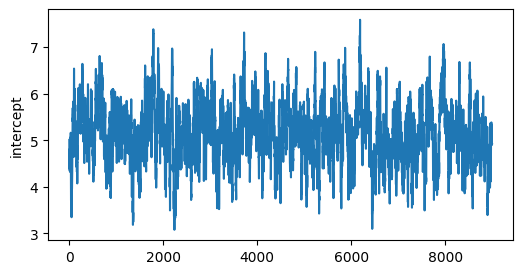

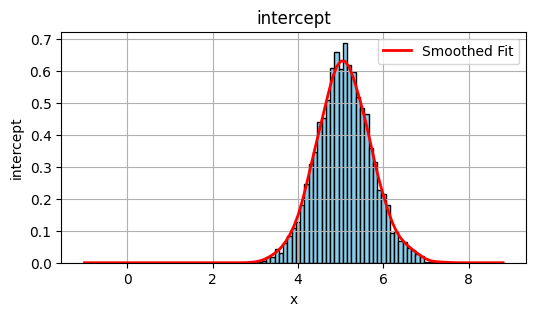

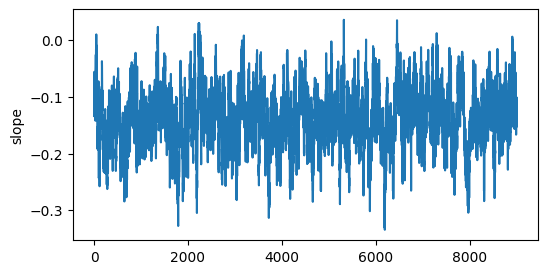

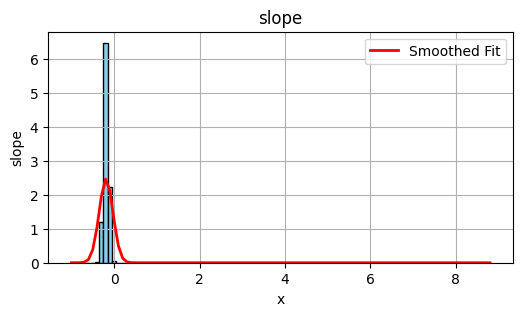

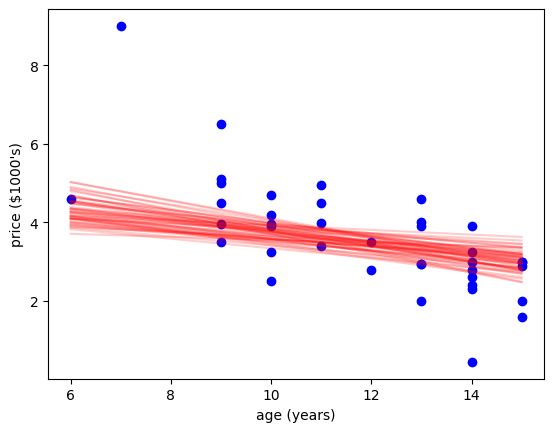

In [54]:
for param, sample in zip(['intercept', 'slope'], samples_3.T):
    
    bins = np.arange(-1, 9.0, 0.1)
    counts, bin_edges = np.histogram(sample, bins=bins)
    counts = counts/len(sample)/0.1

    smoothed_counts = scipy.ndimage.gaussian_filter1d(counts, sigma=1.5)  #Adjust sigma for smoothness


    # Plotting
    fig, axes = plt.subplots(1, figsize=(6, 3))
    axes.plot(sample)
    axes.set_ylabel(param)
    plt.show()
        
    plt.figure(figsize=(6, 3))
    plt.bar(bin_edges[:-1], counts, width=0.1, color='skyblue', edgecolor='black')
    plt.plot(bin_edges[:-1], smoothed_counts, color='red', lw=2, label="Smoothed Fit")
    plt.xlabel('x')
    plt.ylabel(param)
    plt.title( param)
    plt.grid(True)
    plt.legend()
    plt.show()

plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1 = samples_3[np.random.randint(0, len(samples_3))]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

In [51]:
from HMC__no_u_turn import HamiltonianMC_no_uturn

HamiltonianMCMC = HamiltonianMC_no_uturn(reg_log_posterior_calculator, reg_log_posterior_grad_calculator)

start_position = np.array([1.0, 0.0])
samples_4 = HamiltonianMCMC.sample(start_position, n_samples = 10000, burn_in=1000)

/Users/freeklinssen/coding/Hamiltonia_Monte_Carlo_algorithm/HMC__no_u_turn.py:35: RuntimeWarning: divide by zero encountered in scalar power
  while ratio**a > 2**(-a):


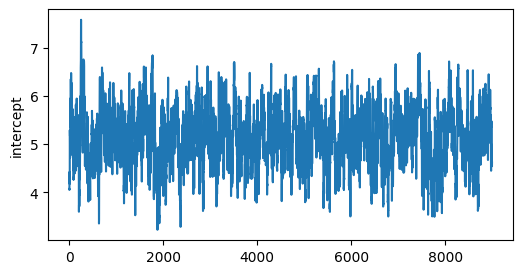

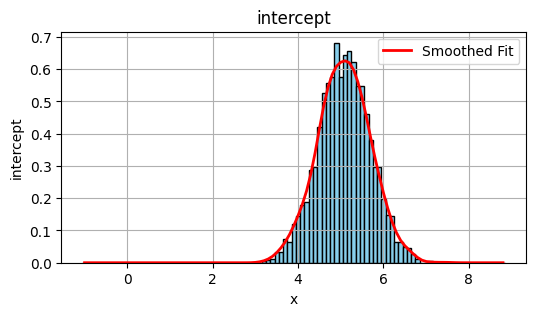

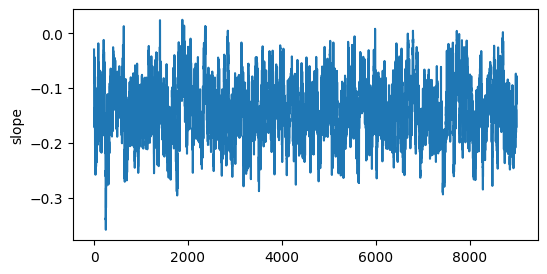

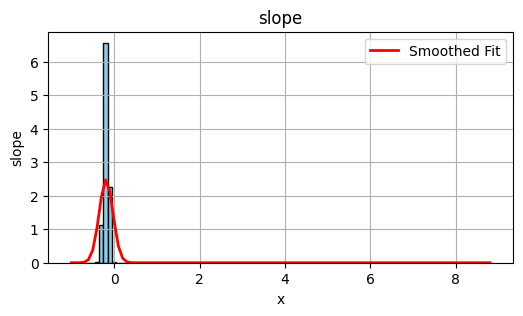

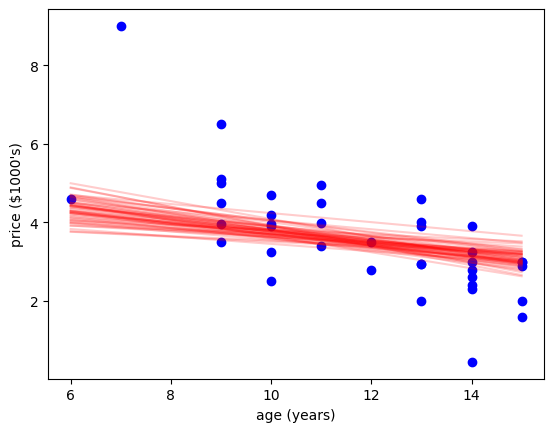

In [52]:
for param, sample in zip(['intercept', 'slope'], samples_4.T):
    
    bins = np.arange(-1, 9.0, 0.1)
    #bins = np.arange(0, 1.01, 0.01)
    counts, bin_edges = np.histogram(sample, bins=bins)
    counts = counts/len(sample)/0.1

    smoothed_counts = scipy.ndimage.gaussian_filter1d(counts, sigma=1.5)  #Adjust sigma for smoothness


    # Plotting
    fig, axes = plt.subplots(1, figsize=(6, 3))
    axes.plot(sample)
    axes.set_ylabel(param)
    plt.show()
        
    plt.figure(figsize=(6, 3))
    plt.bar(bin_edges[:-1], counts, width=0.1, color='skyblue', edgecolor='black')
    plt.plot(bin_edges[:-1], smoothed_counts, color='red', lw=2, label="Smoothed Fit")
    plt.xlabel('x')
    plt.ylabel(param)
    plt.title( param)
    plt.grid(True)
    plt.legend()
    plt.show()

plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1 = samples_4[np.random.randint(0, len(samples_4))]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)